# Dynamics vs. Encroachment

In [1]:
import torch
import mat73
import matplotlib.pyplot as plt
from pathlib import Path
from scipy import stats

import matplotlib
matplotlib.rcParams.update({'font.size': 11})

In [2]:
loadEGC = mat73.loadmat("./data/EGCresultv1.mat")
egc = torch.tensor(loadEGC["egc"]).type('torch.FloatTensor')

num_rho, num_samp = egc.size()
Ns = 32
Nr = 32
num_init = 100 # different initial consitions for simulation
EGC = egc.unsqueeze(-1).repeat(1,1,num_init)

# for different supply
Fractions = torch.zeros(num_rho,num_samp,num_init,5)
## last dim
# 0: fraction of survival
# 1: chaos
# 2: limit cyc
# 3: alt s s
# 4: steady unstable
datapath = "./data/Jul9/"

num_task = 48
for task_id in range(num_task):
    loadF = mat73.loadmat(datapath+"DiveDyn"+str(task_id)+".mat") #Jul9 with 100 init cond and new classifier
    Fractions[[task_id,task_id+48,task_id+96]] = torch.tensor(loadF["Fractions"]).type('torch.FloatTensor')

In [3]:
import math

In [4]:
Fluc = Fractions[:,:,:,1] + Fractions[:,:,:,2]
GStable = 1 - Fluc - Fractions[:,:,:,3]
full_gs = ((GStable == 1.0) & (Fractions[:,:,:,0] == 1.0)).float()

x_mean = []
x_std = []

alt_mean = []
alt_std = []

fl_mean = []
fl_std = []

fgs_mean = []
fgs_std = []

for i in range(60):
    indeces = ((i*0.05<=EGC) & (EGC<(i+1)*0.05)).nonzero(as_tuple=True)
    x_group = EGC[indeces]
    y_group = Fractions[:,:,:,3][indeces]
    y1_group = Fluc[indeces]
    y2_group = full_gs[indeces]
    if x_group.size() != torch.Size([0]):
        x_mean.append(torch.mean(x_group))
        x_std.append(torch.std(x_group)/math.sqrt(len(indeces[0])/num_init))
        alt_mean.append(torch.mean(y_group))
        alt_std.append(torch.std(y_group)/math.sqrt(len(indeces[0])/num_init))
        fl_mean.append(torch.mean(y1_group))
        fl_std.append(torch.std(y1_group)/math.sqrt(len(indeces[0])/num_init))
        fgs_mean.append(torch.mean(y2_group))
        fgs_std.append(torch.std(y2_group)/math.sqrt(len(indeces[0])/num_init))

Text(0, 0.5, 'Fractions')

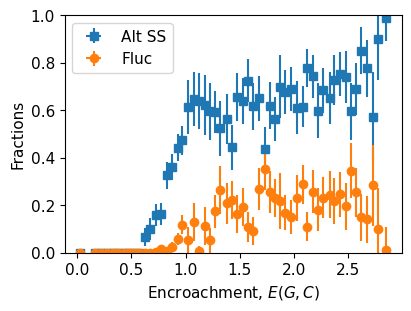

In [5]:
plt.figure(figsize=(4, 3),constrained_layout=True)
plt.errorbar(x_mean,alt_mean, xerr=x_std, yerr= alt_std, marker = 's', ls='none')
plt.errorbar(x_mean,fl_mean, xerr=x_std, yerr= fl_std, marker = 'o', ls='none')

plt.legend(['Alt SS','Fluc'])
#plt.xlim(.0,1.4)
plt.ylim(.0,1.0)
plt.xlabel('Encroachment, $E(G,C)$')
plt.ylabel('Fractions')

Text(0, 0.5, 'Fractions')

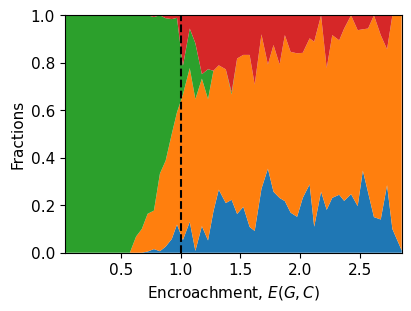

In [6]:
pgs_mean = []

for i in range(len(x_mean)):
    pgs_mean.append(1 - fl_mean[i] - alt_mean[i] - fgs_mean[i])

plt.figure(figsize=(4, 3),constrained_layout=True)
plt.stackplot(x_mean,fl_mean, alt_mean, fgs_mean, pgs_mean)
plt.plot(torch.linspace(1, 1, steps=10),torch.linspace(0.0, 1.0, steps=10),'k--')

plt.ylim(0,1)
plt.xlim(x_mean[0],x_mean[-1])

plt.xlabel('Encroachment, $E(G,C)$')
plt.ylabel('Fractions')
#plt.savefig("../figures/Figure4emb1.eps", format = "eps")

## survival fractions

In [7]:
Eval = torch.zeros(2,30) # first dim: mean and std; second dim: 10 E values
Fval = torch.zeros(2,30) 
Sval = torch.zeros(2,30)
pVal = torch.zeros(30)


for i in range(30):
    Emean = 0.1*i

    Econdi = ((EGC >= Emean - 0.05) & (EGC <= Emean + 0.05))
    Eval[0,i] = EGC[Econdi.nonzero(as_tuple=True)].mean()
    Eval[1,i] = EGC[Econdi.nonzero(as_tuple=True)].std()

    event = ((Fractions[:,:,:,1] == 1.0) | (Fractions[:,:,:,2] == 1.0)) & Econdi
    aevent = (~event) & Econdi # & (Fractions[:,:,:,0] != 1.0)

    fluc = Fractions[:,:,:,0][event.nonzero(as_tuple=True)]
    Fval[0,i] = fluc.mean()
    Fval[1,i] = fluc.std()/math.sqrt(len(fluc)/num_init)

    stdy = Fractions[:,:,:,0][aevent.nonzero(as_tuple=True)]
    Sval[0,i] = stdy.mean()
    Sval[1,i] = stdy.std()/math.sqrt(len(stdy)/num_init)

    #pVal[i] = stats.ttest_ind(fluc,stdy,equal_var=False).pvalue

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


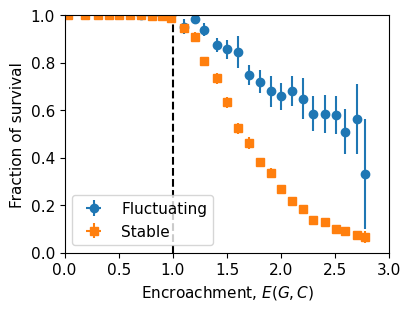

In [10]:
plt.figure(figsize=(4, 3),constrained_layout=True)

plt.errorbar(Eval[0][0:-1],Fval[0][0:-1], xerr=0, yerr= Fval[1][0:-1], marker = 'o',ls='none')
plt.errorbar(Eval[0][0:-1],Sval[0][0:-1], xerr=0, yerr= Sval[1][0:-1], marker = 's',ls='none')

#plt.legend(['Fluctuating','Stable'],loc = "lower left")
plt.plot(torch.linspace(1, 1, steps=10),torch.linspace(0.0, 1.0, steps=10),'k--')

plt.xlim(0,3)
plt.ylim(0,1)
plt.xlabel('Encroachment, $E(G,C)$')
plt.ylabel('Fraction of survival')
plt.savefig("../../figures/Figure4emb2.eps", format = "eps")